<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/generic_cypher_gpt4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai neo4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Generating Cypher queries with GPT-4 on any graph schema

Large language models have a great potential to translate natural language into query language. For example, some people like to use GPT models to translate text to SQL, while others want to use GPT models to construct SPARQL queries. Personally, I prefer exploring how to translate natural language to Cypher query language.
In my experiments, I have noticed there are two approaches to developing an LLM flow that constructs Cypher statements. One option is to provide example queries in the prompt or use the examples to finetune an LLM model. However, the limitation of this approach is that it requires some work to produce the Cypher examples. Therefore, the example Cypher queries must be generated for each graph schema. On the other hand, we can provide an LLM directly with schema information and let it construct Cypher statements based on graph schema information alone. Using the second approach, we could develop a generic Cypher statement model to produce Cypher statements for any input graph schema, as we eliminate the need for any additional work like generating example Cypher statements.
This blog post aims to show you how to implement a Cypher statement-generating model by providing only the graph schema information. We will evaluate the model's Cypher construction capabilities on three graphs with different graph schemas. Currently, the only model I recommend to generate Cypher statements based on only the provided graph schema is GPT-4. Other models like GPT-3.5-turbo or text-davinci-003 aren't that great, and I have yet to find an open-source LLM model that would be good at following instructions in the prompt as well as GPT-4.
## Experiment Setup
I have implemented a Python class that connects to a Neo4j instance and fetches the schema information when initialized. The graph schema information can then be used as input to GPT-4 model.

In [2]:
node_properties_query = """
CALL apoc.meta.data()
YIELD label, other, elementType, type, property
WHERE NOT type = "RELATIONSHIP" AND elementType = "node"
WITH label AS nodeLabels, collect(property) AS properties
RETURN {labels: nodeLabels, properties: properties} AS output

"""

rel_properties_query = """
CALL apoc.meta.data()
YIELD label, other, elementType, type, property
WHERE NOT type = "RELATIONSHIP" AND elementType = "relationship"
WITH label AS nodeLabels, collect(property) AS properties
RETURN {type: nodeLabels, properties: properties} AS output
"""

rel_query = """
CALL apoc.meta.data()
YIELD label, other, elementType, type, property
WHERE type = "RELATIONSHIP" AND elementType = "node"
RETURN {source: label, relationship: property, target: other} AS output
"""

In [3]:
from neo4j import GraphDatabase
from neo4j.exceptions import CypherSyntaxError
import openai


def schema_text(node_props, rel_props, rels):
    return f"""
  This is the schema representation of the Neo4j database.
  Node properties are the following:
  {node_props}
  Relationship properties are the following:
  {rel_props}
  Relationship point from source to target nodes
  {rels}
  Make sure to respect relationship types and directions
  """


class Neo4jGPTQuery:
    def __init__(self, url, user, password, openai_api_key):
        self.driver = GraphDatabase.driver(url, auth=(user, password))
        openai.api_key = openai_api_key
        # construct schema
        self.schema = self.generate_schema()


    def generate_schema(self):
        node_props = self.query_database(node_properties_query)
        rel_props = self.query_database(rel_properties_query)
        rels = self.query_database(rel_query)
        return schema_text(node_props, rel_props, rels)

    def refresh_schema(self):
        self.schema = self.generate_schema()

    def get_system_message(self):
        return f"""
        Task: Generate Cypher queries to query a Neo4j graph database based on the provided schema definition.
        Instructions:
        Use only the provided relationship types and properties.
        Do not use any other relationship types or properties that are not provided.
        If you cannot generate a Cypher statement based on the provided schema, explain the reason to the user.
        Schema:
        {self.schema}

        Note: Do not include any explanations or apologies in your responses.
        """

    def query_database(self, neo4j_query, params={}):
        with self.driver.session() as session:
            result = session.run(neo4j_query, params)
            output = [r.values() for r in result]
            output.insert(0, result.keys())
            return output

    def construct_cypher(self, question, history=None):
        messages = [
            {"role": "system", "content": self.get_system_message()},
            {"role": "user", "content": question},
        ]
        # Used for Cypher healing flows
        if history:
            messages.extend(history)

        completions = openai.ChatCompletion.create(
            model="gpt-4",
            temperature=0.0,
            max_tokens=1000,
            messages=messages
        )
        return completions.choices[0].message.content

    def run(self, question, history=None, retry=True):
        # Construct Cypher statement
        cypher = self.construct_cypher(question, history)
        print(cypher)
        try:
            return self.query_database(cypher)
        # Self-healing flow
        except CypherSyntaxError as e:
            # If out of retries
            if not retry:
              return "Invalid Cypher syntax"
        # Self-healing Cypher flow by
        # providing specific error to GPT-4
            print("Retrying")
            return self.run(
                question,
                [
                    {"role": "assistant", "content": cypher},
                    {
                        "role": "user",
                        "content": f"""This query returns an error: {str(e)} 
                        Give me a improved query that works without any explanations or apologies""",
                    },
                ],
                retry=False
            )


It's interesting how I ended with the final system message to get GPT-4 following my instructions. At first, I wrote my directions as plain text and added some constraints. However, the model wasn't doing exactly what I wanted, so I opened ChatGPT in a web browser and asked it to rewrite my instructions in a manner that GPT-4 would understand. Finally, ChatGPT seems to understand what works best as GPT-4 prompts, as the model behaved much better with this new prompt structure.


The GPT-4 model uses the ChatCompletion endpoint, which uses a combination of system, user, and optional assistant messages when we want to ask follow-up questions. So, we always start with only the system and user message. However, if the generated Cypher statement has any syntax error, the self-healing flow will be started, where we include the error in the follow-up question so that GPT-4 can fix the query. Therefore, we have included the optional history parameter for Cypher self-healing flow.

The run function starts by generating a Cypher statement. Then, the generated Cypher statement is used to query the Neo4j database. If the Cypher syntax is valid, the query results are returned. However, suppose there is a Cypher syntax error. In that case, we do a single follow-up to GPT-4, provide the generated Cypher statement it constructed in the previous call, and include the error from the Neo4j database. GPT-4 is quite good at fixing a Cypher statement when provided with the error.

The self-healing Cypher flow was inspired by others who have used similar flows for Python and other code. However, I have limited the follow-up Cypher healing to only a single iteration. If the follow-up doesn't provide a valid Cypher statement, the function returns the "Invalid Cypher syntax response".
Let's now test the capabilities of GPT-4 to construct Cypher statements based on the provided graph schema only.

We will begin with a simple airport route graph, which is available [as the GDS project in Neo4j Sandbox](https://sandbox.neo4j.com/?usecase=graph-data-science2).





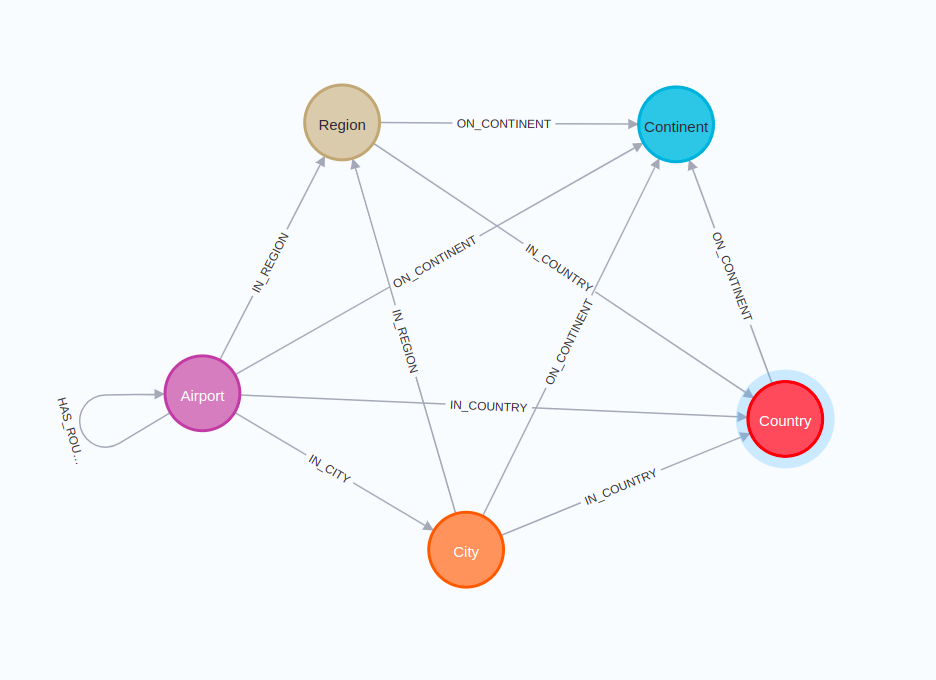

This graph schema is relatively simple. The graph contains information about airports and their routes. Additionally, information about the airport's city, region, country, and continent is stored as separate nodes.

We can instantiate the Python class used to query the airport graph with the following Python code:

In [4]:
openai_key = "INSERT_OPENAI_API_KEY"

In [5]:
gds_db = Neo4jGPTQuery(
    url="bolt://18.207.187.166:7687",
    user="neo4j",
    password="preferences-accomplishments-vent",
    openai_api_key=openai_key,
)


Now we can begin our experiment. First, we will begin with a simple question.

In [6]:
gds_db.run("""
What is the city with the most airports?
""")

MATCH (a:Airport)-[:IN_CITY]->(c:City)
RETURN c.name AS City, COUNT(a) AS NumberOfAirports
ORDER BY NumberOfAirports DESC
LIMIT 1


[['City', 'NumberOfAirports'], ['London', 6]]

Great start. The Cypher statement was correctly generated, and we found that London has six airports. Next, let's try something more complex.

In [7]:
gds_db.run("""
calculate the minimum, maximum, average, and standard deviation of the number of flights out of each airport.
""")

MATCH (a:Airport)-[r:HAS_ROUTE]->(:Airport)
WITH a, count(r) as num_flights
RETURN min(num_flights) as min_flights, max(num_flights) as max_flights, avg(num_flights) as avg_flights, stDev(num_flights) as stddev_flights


[['min_flights', 'max_flights', 'avg_flights', 'stddev_flights'],
 [1, 307, 20.905362776025285, 38.28730861505158]]

Quite nice. The GPT-4 model correctly assumed that flights relate to the HAS_ROUTE relationship. Additionally, it accurately aggregates flights per airport, then calculates the specified metrics.

Let's now throw it a curveball. We will ask the model to calculate the variance since Cypher doesn't have any built-in function to calculate the variance.

In [8]:
gds_db.run("""
calculate the variance of the number of flights out of each airport.
""")

The provided schema does not have information about the number of flights for each airport. Therefore, it is not possible to calculate the variance of the number of flights out of each airport using the given schema.
Retrying
As mentioned earlier, the provided schema does not have information about the number of flights for each airport. Therefore, it is not possible to create a query to calculate the variance of the number of flights out of each airport using the given schema.


'Invalid Cypher syntax'

First of all, GPT-4 provided explanations when explicitly told not to. Secondly, neither Cypher statements make any sense. In this example, even the self-healing flow didn't succeed since we are not dealing with a Cypher syntax error but a GPT-4 system malfunction.

I have noticed that GPT-4 struggles when it needs to perform multiple aggregations using different grouping keys in a single Cypher statement. Here it wanted to split the statement into two parts (which don't work either), but in other cases it wants to borrow syntax from SQL.

However, GPT-4 is quite obedient and provides the specified results from the database as instructed by the user.

In [9]:
gds_db.run("""
Find the shortest route between ATL and IAH airports
and return only the iata and runways property of the nodes as a map object
""")

MATCH (atl:Airport {iata: "ATL"}), (iah:Airport {iata: "IAH"}), path = shortestPath((atl)-[:HAS_ROUTE*]-(iah))
WITH nodes(path) AS airports
UNWIND airports AS airport
RETURN {iata: airport.iata, runways: airport.runways} AS airportInfo


[['airportInfo'],
 [{'iata': 'ATL', 'runways': 5}],
 [{'iata': 'IAH', 'runways': 5}]]

Here is where the power of GPT-4 shines. The more specific we are in what we want to find and how we want the results to be structured, the better it works.
We can also test if it knows how to use the GDS library.

In [10]:
print(gds_db.construct_cypher("""
Calculate the betweenness centrality of airports using the Graph Data Science library
"""))

CALL gds.betweenness.stream({
  nodeProjection: 'Airport',
  relationshipProjection: {
    HAS_ROUTE: {
      type: 'HAS_ROUTE',
      orientation: 'UNDIRECTED'
    }
  }
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).id AS airportId, score
ORDER BY score DESC


Well, the constructed Cypher statement looks fine. However, there is only one problem. The generated Cypher statement uses the anonymous graph projection, which was deprecated and removed in GDS v2. Here we see some issues arising from GPT-4's knowledge cutoff date. Unfortunately, it looks like GDS v2 was released after the knowledge cutoff date, and therefore the new syntax is not baked into GPT-4. Therefore, at the moment, the GPT-4 model doesn't provide valid GDS procedures.

If you pay attention, you will also notice that GPT-4 never uses the Cypher subquery syntax, which is again another syntax change that was added after the knowledge cutoff date.

Interestingly, if you calculate any of the values from graph algorithms and store them as node property, the GPT-4 has no problem retrieving that.

In [11]:
gds_db.run("""
Use PageRank to find the five most important airports and return their descr and pagerank value
""")

MATCH (a:Airport)
RETURN a.descr, a.pagerank
ORDER BY a.pagerank DESC
LIMIT 5


[['a.descr', 'a.pagerank'],
 ['Dallas/Fort Worth International Airport', 11.97978260670334],
 ["Chicago O'Hare International Airport", 11.162988178920267],
 ['Denver International Airport', 10.997299338126387],
 ['Hartsfield - Jackson Atlanta International Airport', 10.389948350302957],
 ['Istanbul International Airport', 8.42580121770578]]

It looks like Dallas and Chicago have the highest PageRank scores.
## Healthcare sandbox
You might say that the airport sandbox might have been part of the training data of GPT-4. That is definitely a possibility. Therefore, let's test GPT-4 ability to construct Cypher statements on the latest Neo4j Sandbox project dealing with healthcare data, published between December 2022 and January 2023. That should be after the GPT-4 knowledge cutoff date.

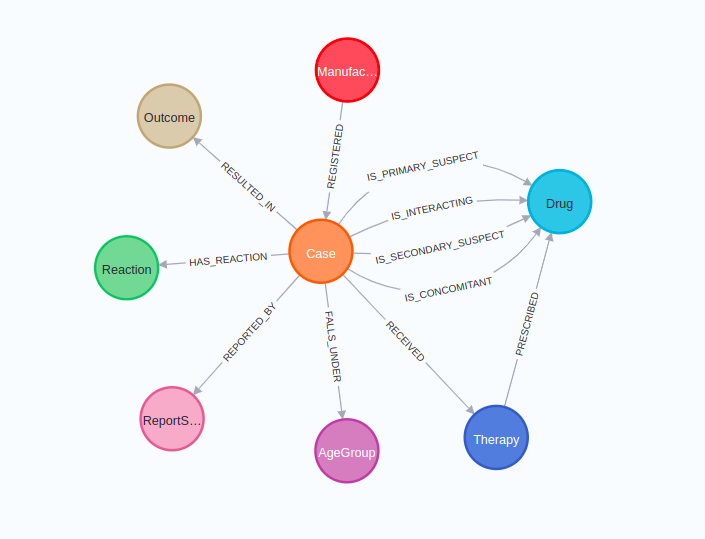

The healthcare graph schema revolves around adverse drug event cases. Therefore, each case is related to relevant drugs. In addition, other information is available such as the age group, outcome, and reaction. Here, I took the examples from the sandbox guide as I am not familiar with the adverse drug events domain.

In [12]:
hc_db = Neo4jGPTQuery(
    url="bolt://3.216.123.73:7687",
    user="neo4j",
    password="reenlistment-superstructures-shafts",
    openai_api_key=openai_key,
)

In [13]:
hc_db.run("""
What are the top 5 side effects reported?
""")

MATCH (c:Case)-[:HAS_REACTION]->(r:Reaction)
RETURN r.description as SideEffect, COUNT(*) as Frequency
ORDER BY Frequency DESC
LIMIT 5


[['SideEffect', 'Frequency'],
 ['Fatigue', 303],
 ['Product dose omission issue', 285],
 ['Headache', 272],
 ['Nausea', 256],
 ['Pain', 253]]

It would be interesting to learn how did GPT-4 know that side effects can be found as the Reaction nodes. Even I couldn't find that without any details about the graph. Are there graph out there with similar schema, or is the knowledge cutoff date of GPT-4 not that accurate? Or does it only have great intuition to find relevant data based on node labels and their properties.

Let's try something more complex.

In [14]:
hc_db.run("""
What are the top 3 manufacturing companies with the most reported side effects?
""")

MATCH (m:Manufacturer)-[:REGISTERED]->(c:Case)-[:HAS_REACTION]->(r:Reaction)
RETURN m.manufacturerName, COUNT(r) as sideEffectsCount
ORDER BY sideEffectsCount DESC
LIMIT 3


[['m.manufacturerName', 'sideEffectsCount'],
 ['TAKEDA', 5058],
 ['PFIZER', 3219],
 ['NOVARTIS', 1823]]

Here, we can see that GPT-4 is very specific in our request. Since we are asking for the count of reported side effects, it expands to Reaction nodes and counts them. On the other hand, we could request only the number of cases.

In [15]:
hc_db.run("""
What are the top 3 manufacturing companies with the most reported cases?
""")

MATCH (m:Manufacturer)-[:REGISTERED]->(c:Case)
RETURN m.manufacturerName, COUNT(c) as case_count
ORDER BY case_count DESC
LIMIT 3


[['m.manufacturerName', 'case_count'],
 ['TAKEDA', 617],
 ['CELGENE', 572],
 ['PFIZER', 513]]

Now, lets do something where GPT-4 has to do both filtering and aggregating.

In [16]:
hc_db.run("""
What are the top 5 drugs whose side effects resulted in Death of patients as an outcome?
""")

MATCH (d:Drug)-[:IS_PRIMARY_SUSPECT|:IS_SECONDARY_SUSPECT|:IS_CONCOMITANT|:IS_INTERACTING]->(c:Case)-[:RESULTED_IN]->(o:Outcome)
WHERE o.outcome = "Death"
RETURN d.name, COUNT(*) as count
ORDER BY count DESC
LIMIT 5


[['d.name', 'count']]

Something that happens sometimes is that GPT-4 messes up the relationship direction. For example, the relationships from the Drug to the Case node should have a reverse direction. Additionally, the Sandbox guide uses only the IS_PRIMARY_SUSPECT relationship type, but we can't blame the GPT-4 model due to the question's ambiguity.

Note that GPT-4 is not deterministic. Therefore, it may return correct relationship directions and sometimes not. For me, it worked correctly one day and not the other. However, I got consistent results within the same day, so who knows what is happening behind the scenes.

What I found interesting is that the GPT-4 model knew that the outcome property contains information about the death of patients. But more than that, it knew that the death value should be capitalized, which makes me think the model saw this dataset in one form or another.

## Custom astronomical dataset
I have decided to construct a custom astronomical dataset that the model definitely hasn't seen during its training since it didn't exist until I started writing this post. It is very tiny, but good enough to test out GPT-4 generalization ability. I have created a [blank project on Neo4j Sandbox](https://sandbox.neo4j.com/?usecase=blank-sandbox) and then seeded the database with the following script.

In [17]:
astro_db = Neo4jGPTQuery(
    url="bolt://35.171.160.87:7687",
    user="neo4j",
    password="discontinuance-fifths-sports",
    openai_api_key=openai_key,
)

In [18]:
url = "https://gist.githubusercontent.com/tomasonjo/52b2da916ef5cd1c2adf0ad62cc71a26/raw/a3a8716f7b28f3a82ce59e6e7df28389e3cb33cb/astro.cql"
astro_db.query_database("CALL apoc.cypher.runFile($url)", {'url':url})
astro_db.refresh_schema()

The constructed graph has the following schema.

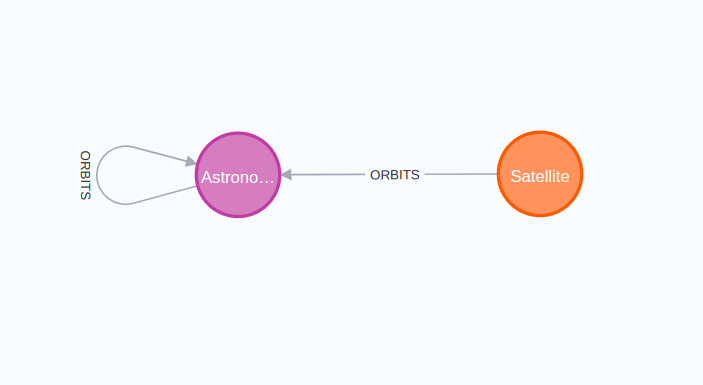

The database contains planets within our solar system that orbit the sun. Additionally, satellites like ISS, the moon, and Hubble Telescope are included.

In [19]:
astro_db.run("""
What orbits the Earth?
""")

MATCH (ao:AstronomicalObject {name: "Earth"})<-[:ORBITS]-(o)
RETURN o.name, labels(o)


[['o.name', 'labels(o)'],
 ['Hubble Space Telescope', ['Satellite']],
 ['ISS', ['Satellite']],
 ['Moon', ['Satellite']]]

Remember, the GPT-4 only know that there are satellites and astronomical objects in the database. Astronomical objects orbit other astronomical objects, while satellites can only orbit objects. It looks like it used its knowledge to assume that only a satellite would orbit the Earth, which is impressive. We can observe that GPT-4 probably makes a lot of assumption based on its baked knowledge to help us with our queries.

Let's dig deeper.

In [20]:
astro_db.run("""
Does ISS orbits the Sun?
""")

MATCH (s:Satellite {name: "ISS"})-[:ORBITS]->(a:AstronomicalObject {name: "Sun"})
RETURN s.name as Satellite, a.name as AstronomicalObject


[['Satellite', 'AstronomicalObject']]

So, the ISS doesn't directly orbit the sun. We can rephrase our question.

In [21]:
astro_db.run("""
Does ISS orbits the Sun? Find any path between them
and return names of nodes in the path
""")

MATCH path = (iss:Satellite {name: "ISS"})-[:ORBITS*]->(sun:AstronomicalObject {name: "Sun"})
RETURN [node in nodes(path) | node.name] AS path_names


[['path_names'], [['ISS', 'Earth', 'Sun']]]

Now, it uses a variable-length path pattern to find if ISS orbits the sun by proxy. Of course, we gave it a hint to use that, but it is still remarkable. For the final example, let's observe how good GPT-4 is at guessing never-seen-before property values.

In [22]:
astro_db.run("""
What's the altitude difference between ISS and Hubble telescope
""")

To find the altitude difference between ISS and Hubble telescope, you can use the following Cypher query:

```cypher
MATCH (s1:Satellite {name: "ISS"}), (s2:Satellite {name: "Hubble Telescope"})
RETURN abs(s1.altitude - s2.altitude) as altitude_difference
```
Retrying
```cypher
MATCH (s1:Satellite {name: "ISS"}), (s2:Satellite {name: "Hubble Telescope"})
RETURN abs(s1.altitude - s2.altitude) as altitude_difference
```


'Invalid Cypher syntax'

To tell you the truth, I am kind of relieved GPT-4 didn't guess correctly that Hubble is stored in the database as "Hubble Space Telescope". Other than that, the generated Cypher statement is perfectly valid.
Summary
GPT-4 has a great potential to generate Cypher statements based on only the provided graph schema. My opinion is that it has seen a lot of datasets and graph models during its training, so it is kind of good at guessing which properties to use and sometimes even their values. However, you can always provide the model with instructions about which properties to use and specify the exact values if the model isn't performing well on your specific graph model. The limitations I have observed during this experiment are the following:
* Multiple aggregations with different grouping keys are a problem
* Version two of the Graph Data Science library is beyond the knowledge cutoff date
* Sometimes it messes up the relationship direction (not frequently, though)
* The non-deterministic nature of GPT-4 makes it feel like you are dealing with a horoscope-based model, where identical queries work in the morning but not in the afternoon
* Sometimes the model bypasses system instructions and provides explanations for queries

Using the schema-only approach to GPT-4 can be used for experimental setups to help developers or researchers that don't have malicious intents to interact with the graph database. On the other hand, if you want to build something more production-ready, I would recommend using the approach of providing examples of Cypher statements.